## Step 1: Importing the packages

In [2]:
#library which integrates code with operating system
import os 

# used to generate random vector of data/noise as input for the generator
import random 

# helps us write user-frindly code, especially when dealing with varaibles within functions
import argparse 

#main PyTorch framework and libraries we need to use
import torch 
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np #used for most of our mathematical oprations

#packages for creating our plots and animations
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128

## Step 2: Getting data and defining hyperparameters

In [4]:
# Root directory for dataset
dataroot = #enter file path to target folder here

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 8 #128

# Spatial size of training images. All images will be resized to this
# size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3 (use 1 for black & white)
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

## Step 3: Loading and plotting our intial data

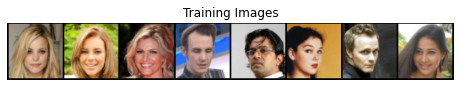

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,# the folder where the data is located
                           #reshaping the data in the form we desire
                           transform=transforms.Compose([
                               transforms.Resize(image_size),#resizing
                               transforms.CenterCrop(image_size), #cropping and centering
                               transforms.ToTensor(), #tranforming image data to tensors
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #normalising the data
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True, #shuffing images so the  genrator doesn't overfit on the sequence
                                         num_workers=workers)

# Decide which device we want to run on. Basically telling the model to run on the GPU if its available.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some random training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Step 4: Initialising our weights

In [4]:
# creating a function which will intialise our weights
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1.0:
        #initalisation of weights based on Normal distro
        nn.init.normal_(m.weight.data, 0.0, 0.02) #mean 0, std.dev 0.02
    elif classname.find('BatchNorm') != -1.0: 
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

## Step 4: Defining the Generator class & creating the Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu): #defininng the initial function
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential( #squencing the main as a sequential neural network
            # input is Z, going into a convolution
            # ConvTranspose2d applies a 2D transposed convolution operator over an input image composed of several input planes.
            #https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
            # we can change the keral size if we wish(third parameter)
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False), 
            
            #Batch Normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension) 
            #as described in the paper Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
            #https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
            #notice the input has to match the second arguement of the above function (the output channel)
            nn.BatchNorm2d(ngf * 8),
            
            ##using the reLU as the activation function
            nn.ReLU(True),
            
            #repeating the above steps three more times for three different sizes
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
            #this leaves us with our desired output size
            # state size. (nc) x 64 x 64
        )

    #creating a function for the forward propagation
    def forward(self, input):
        return self.main(input)

In [6]:
#After defining the Generator in the previous step, we have to now create the Generator object

#here we are asking our gpu (or cpu) to create our Generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Step 4: Defining the Discriminator class & creating the Discriminator

In [7]:
# The Discriminator is essentially the revese of the Generator, so the architecture is very similar
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            #Conv2d applies a 2D convolution over an input signal composed of several input planes.
            #https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            
            # Leaky ReLU has beenfis over regual ReLU for the discriminator (you can still use regular ReLU)
            nn.LeakyReLU(0.2, inplace=True),
            
            # Repeating the  steps, like the Generator, except this time with descneding sizes
            # This is because are taking the ouput of the Generator as an input, and shrinking it down to a data value
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            
            #using a sigmoid function to determine whether the prediction is for real or fake
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Step 5: Creating a binary cross-entropy loss function

In [9]:
# info on binary cross-entropy:
# https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
# torch.randn returns a tensor filled with random numbers from a uniform distribution on the interval [0, 1)[0,1)
# https://pytorch.org/docs/stable/generated/torch.rand.html
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both Generator and Discriminator
# Notes on Adam Optimisers:
# https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/#:~:text=Adam%20is%20a%20replacement%20optimization,sparse%20gradients%20on%20noisy%20problems.
# Notes on TORCH.OPTIM:
# https://pytorch.org/docs/stable/optim.html
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################

        # (1) Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))

        ###########################

        ## Train with all-real batch
        netD.zero_grad()

        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size, 1), real_label, device=device, dtype=torch.float).view(-1)

        # Forward pass real batch through Discriminator
        output = netD(real_cpu).view(-1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)

        # Calculate gradients for Discriminator in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate fake image batch with Generator
        fake = netG(noise)
        label.fill_(fake_label)

        # Classify all fake batch with Discriminator
        output = netD(fake.detach()).view(-1)

        # Calculate Discriminator's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake

        # Update Discriminator
        optimizerD.step()

        ############################

        # (2) Update Generator network: maximize log(D(G(z)))

        ###########################

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        # Since we just updated Discriminator, perform another forward pass of all-fake batch through Discriminator
        output = netD(fake).view(-1)

        # Calculate Generator's loss based on this output
        errG = criterion(output, label)

        # Calculate gradients for Generator
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update Generator
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the Generator is doing by saving Generator's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()

           # for item in fake: 
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

               # img_list.append(vutils.make_grid(item,normalize=True))

        iters += 1

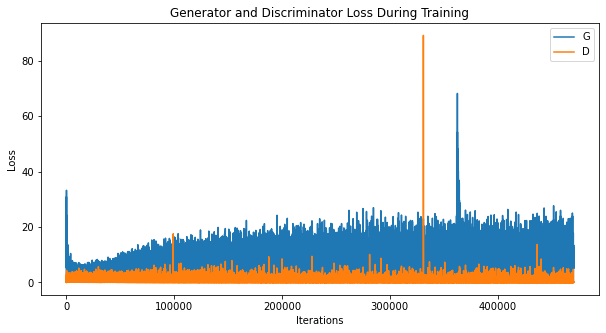

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

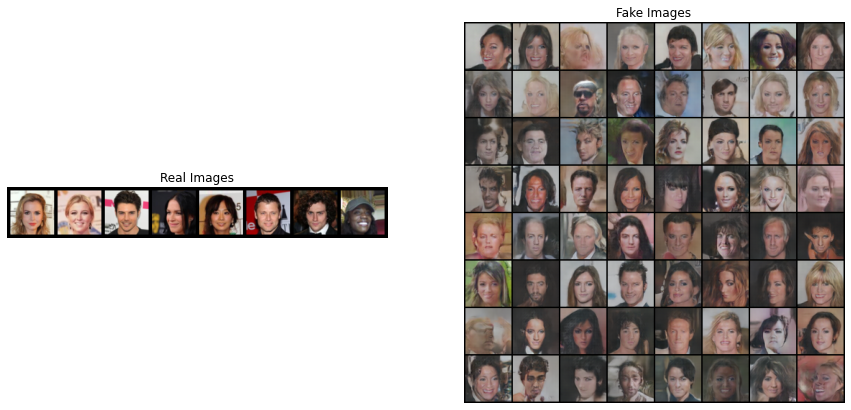

In [12]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=500, blit=True)

HTML(ani.to_jshtml())